# Word-Level Text Generation

## Setup

In [ ]:
!pip install fastai2

from fastai2.text.all import *
from pathlib import Path
import urllib.request
import warnings

     |████████████████████████████████| 184kB 5.0MB/s 


## Text

In [ ]:
# to clean, run !rm -rf data dta_tok
Path("data").mkdir(exist_ok=True)
urllib.request.urlretrieve("https://s3.amazonaws.com/text-datasets/nietzsche.txt", "data/nietzsche.txt")
# Other possible text datasets
# Shakespare sonnets, https://raw.githubusercontent.com/michaelrzhang/Char-RNN/master/data/sonnet.txt
# Obama speaches, https://raw.githubusercontent.com/michaelrzhang/Char-RNN/master/data/obama.txt

('data/nietzsche.txt', <http.client.HTTPMessage at 0x7f2e3f4319b0>)

In [ ]:
# let us look at the beginning of file
get_files("data")[0].read()[:200]

'PREFACE\n\n\nSUPPOSING that Truth is a woman--what then? Is there not ground\nfor suspecting that all philosophers, in so far as they have been\ndogmatists, have failed to understand women--that the terrib'

In [ ]:
dls = TextDataLoaders.from_folder("data", is_lm=True, valid_pct=0)

In [ ]:
dls.show_batch()

,text,text_
0,"xxbos xxup xxunk \n\n\n xxup supposing that xxmaj truth is a woman -- what then ? xxmaj is there not ground \n for xxunk that all philosophers , in so far as they have been \n dogmatists , have xxunk to understand women -- that the terrible \n seriousness and clumsy xxunk with which they have usually paid \n their xxunk to xxmaj truth , have been xxunk and unseemly methods for","xxup xxunk \n\n\n xxup supposing that xxmaj truth is a woman -- what then ? xxmaj is there not ground \n for xxunk that all philosophers , in so far as they have been \n dogmatists , have xxunk to understand women -- that the terrible \n seriousness and clumsy xxunk with which they have usually paid \n their xxunk to xxmaj truth , have been xxunk and unseemly methods for \n"
1,"xxunk of movement , there are valuations , or to speak \n more plainly , physiological demands , for the maintenance of a definite \n mode of life xxmaj for example , that the certain is worth more than the \n uncertain , that illusion is less valuable than "" truth "" such valuations , \n in spite of their xxunk importance for xxup us , might notwithstanding be \n only superficial","of movement , there are valuations , or to speak \n more plainly , physiological demands , for the maintenance of a definite \n mode of life xxmaj for example , that the certain is worth more than the \n uncertain , that illusion is less valuable than "" truth "" such valuations , \n in spite of their xxunk importance for xxup us , might notwithstanding be \n only superficial valuations"
2,"will to the causa xxunk . \n\n 10 . xxmaj the eagerness and subtlety , i should even say craftiness , with \n which the problem of "" the real and the apparent world "" is dealt with at \n present throughout xxmaj europe , furnishes food for thought and attention ; and \n he who hears only a "" will to xxmaj truth "" in the background , and nothing else","to the causa xxunk . \n\n 10 . xxmaj the eagerness and subtlety , i should even say craftiness , with \n which the problem of "" the real and the apparent world "" is dealt with at \n present throughout xxmaj europe , furnishes food for thought and attention ; and \n he who hears only a "" will to xxmaj truth "" in the background , and nothing else ,"
3,"more xxunk time of it ; eventually , however , he finds \n that precisely thereby he is also condemned to invent -- and , who knows ? \n perhaps to xxup discover the new . \n\n 13 . xxmaj psychologists should xxunk themselves before putting down the \n instinct of self - preservation as the xxunk instinct of an organic \n being . a living thing seeks above all to xxup","xxunk time of it ; eventually , however , he finds \n that precisely thereby he is also condemned to invent -- and , who knows ? \n perhaps to xxup discover the new . \n\n 13 . xxmaj psychologists should xxunk themselves before putting down the \n instinct of self - preservation as the xxunk instinct of an organic \n being . a living thing seeks above all to xxup xxunk"
4,"not imagine it possible to xxunk this \n thought from the "" willing , "" as if the will would then remain over ! \n xxmaj in the third place , the will is not only a complex of sensation and \n thinking , but it is above all an xxup emotion , and in fact the emotion of the \n command . xxmaj that which is termed "" freedom of the","imagine it possible to xxunk this \n thought from the "" willing , "" as if the will would then remain over ! \n xxmaj in the third place , the will is not only a complex of sensation and \n thinking , but it is above all an xxup emotion , and in fact the emotion of the \n command . xxmaj that which is termed "" freedom of the will"
5,"and more refined atheism -- is once more \n disguised . "" ni xxunk , ni xxunk , also , is what you want ; and \n therefore "" xxunk for natural xxunk it not so ? xxmaj but , as has been \n said , that is interpretation , not text ; and somebody might come along , \n who , with opposite intentions and m

## Model Fine-Tuning

In [ ]:
learn = language_model_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy, pretrained=True)

In [ ]:
# to ignore warnings about missing validaton set
with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  learn.fine_tune(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,5.161004,None,None,00:04


epoch,train_loss,valid_loss,accuracy,time
0,4.430636,None,None,00:06
1,4.221169,None,None,00:06
2,4.042874,None,None,00:06
3,3.908915,None,None,00:06


## Text Generation

In [ ]:
TEXT = "There is something"
N_SENTENCES = 2
N_WORDS = 30
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]
preds

['There is something that is \n called " self - denial " ( or " non - freedom " ) . One must make use of " free will " , and',
 'There is something in Asia that has been a \n DOWNWARDS spirit of the \n present century and a new , more refined type of \n Asia -- which is']

# Character-Level DNA Generation

## Data

In [ ]:
dt = pd.read_csv("https://raw.githubusercontent.com/ML-Bioinfo-CEITEC/ECCB2020/master/data/intergenomic_seqs_50k.csv")
dt = dt[:5000]   # take first 5000 (only 10% of data)

# chr1 is used for validation
train = dt[dt.chr!="1"]
valid = dt[dt.chr=="1"]

print(dt.shape, train.shape, valid.shape, len(dt.seq[0]))
dt.head()


(5000, 4) (4661, 4) (339, 4) 200


,chr,start,end,seq
0,17,14239397,14239596,AACTGGGATTCACAGGAGCTTAATGGAGCACATGATGTTAAGTGAAGTGAGCCAGGCACAAAAAGACAACTACCACGTGATCTGACTTATGTGGAATGTAAAACAATTGAACTCATGGAAGCAGAGAGTAGAATGGAGGATACCAGGGGCTGGGAGGCAGGGGTTTGGGGAGACGGTGAAAGCGTTCTAAAGTGTAGTTA
1,X,90928374,90928573,GCTAGTTGTATGGTTAGCAGCAAGATATTTTTTCTCTCTGATCTTTAATTTTCATATTTAAATTTGGCTAAGAGTACTTGCCTCTTAAAACTGTGTTGCTGGTATTACCAGAGTGTGGTATAATTAAAATATATATTTGCTTTTTGTCACCAGTTTCTCACACAGTACATCAAAAGCCCTTGCAATTTTCTGAGTGATAA
2,3,104278717,104278916,GACTTTGTAGACTTGTGTGACCTGTGTGCCTCCCTCTCCCCCCAAAAAAAACAAAAAAAATAAAGGATCTTGGGAAAGACTATATAAAAGGCAAGACTCCTTTAATGGAGGGGATATGCTAGATTGCCTCCCATTATGGCCCATGCCAAAGTGTTTAAACTTAGAAAAATGGTTCCAGTTTACTTCTGGGCTTAAAAATC
3,4,187089054,187089253,ATGTTAACACCAAATCAGTCCATCCTAATTATCACTCAAAAATCAAACATTTTTTAGGGAGGCAAAAACTGTCATGAGAACTACAATTTGATTTGGAGACTATTTCACTTATACAGTTTCTTCACATGATGACCAGCCTTCTTTCTTTAGTAATGGTTATTACTATGGCCATTGCTGTTAATTCTGTGACTTATCACTTC
4,2,137742849,137743048,GCAGGAGCTCTATCTGTTTGGACTAGTTCAGCCCCATCTCTTTTGGGGTGACTCGGGTGATGCTAAGCTTCCCAGGGCCATTGTGTTCTGTCTTCTGCCTCTGACTTTTTCCCTGCTACCCACATGAGCTTCTGCTATGCTCTCTTCTTTCCTGTCCAGAAATCATGTAGTAAGATGCTTTTTGGCTGGAGACCCTGAAA


In [ ]:
# splitting the file into training and test part

!rm -rf split_tok
!rm -rf split

Path("split/train/1/").mkdir(parents=True)
Path("split/valid/1/").mkdir(parents=True)

for i, s in enumerate(train.seq):
  open("split/train/1/seq"+str(i)+".txt", 'w').writelines([s])
for i, s in enumerate(valid.seq):
  open("split/valid/1/seq"+str(i)+".txt", 'w').writelines([s])

## Tokenizer

In [ ]:
!wget https://raw.githubusercontent.com/ML-Bioinfo-CEITEC/ECCB2020/master/notebooks/genomic_tokenizer2.py
from genomic_tokenizer2 import tkn2

--2020-08-31 14:06:39--  https://raw.githubusercontent.com/ML-Bioinfo-CEITEC/ECCB2020/master/notebooks/genomic_tokenizer2.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 565 [text/plain]
Saving to: ‘genomic_tokenizer2.py.1’

genomic_tokenizer2. 100%[===================>]     565  --.-KB/s    in 0s      

2020-08-31 14:06:39 (32.9 MB/s) - ‘genomic_tokenizer2.py.1’ saved [565/565]



In [ ]:
tkn2("CGGCTAGC")

(#8) ['C','G','G','C','T','A','G','C']

## Data Loaders

In [ ]:
dls_lm = TextDataLoaders.from_folder(Path("./split"), bs=128, seed=42, 
                                   is_lm=True, 
                                   tok_tfm=tkn2, seq_len=50)

In [ ]:
dls_lm.show_batch()

,text,text_
0,G C C T G G C C A A T A T G G T G A A A C C C A A T C T C T A C T A A A A A A T A C A A A T A T A T,C C T G G C C A A T A T G G T G A A A C C C A A T C T C T A C T A A A A A A T A C A A A T A T A T G
1,A G C A A A G T T T C A G G A T A C C A A A C C A A T G T A C A C A A A G C A A T A G A A C T A C T,G C A A A G T T T C A G G A T A C C A A A C C A A T G T A C A C A A A G C A A T A G A A C T A C T A
2,G T T T T T C A T G T G T C G T G G A T C T G G A T A C A G G C T G T A T G C T G A G A A T G A T G,T T T T T C A T G T G T C G T G G A T C T G G A T A C A G G C T G T A T G C T G A G A A T G A T G G
3,T C G G A A A C T A A A A C T A A A T G C C C T G T A G A A T T A T C A A T C A T G T A A A T C C A,C G G A A A C T A A A A C T A A A T G C C C T G T A G A A T T A T C A A T C A T G T A A A T C C A G
4,T C A G T C A G T C A T C A G G G A G A A T C T A A A A T C T G G C A A C T G A A G A A C A G A C A,C A G T C A G T C A T C A G G G A G A A T C T A A A A T C T G G C A A C T G A A G A A C A G A C A C
5,C T G T C T A T G C T T C C A G T G A A A A G A G A A G C A A A G C T A T A G G A A A T T G G A A A,T G T C T A T G C T T C C A G T G A A A A G A G A A G C A A A G C T A T A G G A A A T T G G A A A G
6,A A A A A T G T A A T C T A A T A C A T T C A A A A A C T T G T G C T C A A G A G A A G G A A C A G,A A A A T G T A A T C T A A T A C A T T C A A A A A C T T G T G C T C A A G A G A A G G A A C A G A
7,G T C C T A T G A A G T A T T T G T A C C A T A A T A T T G T A G G C T C C T A T A C A T T A G T G,T C C T A T G A A G T A T T T G T A C C A T A A T A T T G T A G G C T C C T A T A C A T T A G T G A
8,G C A A A C A A A A C A A A G T C A A G T A A A A A A C A C A T A A A A A A C C T C T A T G C T T T,C A A A C A A A A C A A A G T C A A G T A A A A A A C A C A T A A A A A A C C T C T A T G C T T T C


## Model Training

In [ ]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, pretrained=False, 
    metrics=[accuracy, Perplexity()])

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.0003311311302240938)

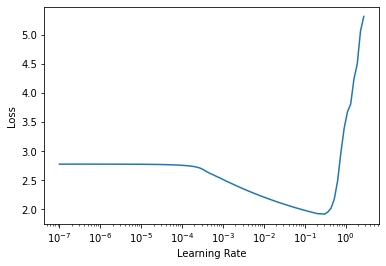

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(2, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.551815,1.369198,0.294755,3.932197,00:52
1,1.429831,1.355422,0.314843,3.878396,00:51


## DNA Generation

In [ ]:
learn.predict("CGCAT", n_words=20, temperature=1)[::2]

'CGCATCAGGAAATCGCTATAGTGTT'